In [ ]:
from astropy.table import Table
import torch

import matplotlib.pyplot as plt
from bliss.reporting import get_snr

import numpy as np

from bliss.datasets.galsim_blends import generate_individual_dataset
from bliss.datasets.lsst import get_default_lsst_psf

### Check that final individual galaxy dataset is correct

In [ ]:
cat = Table.read("../../../data/OneDegSq.fits")
psf = get_default_lsst_psf()
len(cat)

858502

In [ ]:
# create small dataset of 10k galaxies, no replacement
ds = generate_individual_dataset(30_000, cat, psf, slen=53, replace=False)

100%|██████████| 30000/30000 [00:40<00:00, 737.22it/s]


In [ ]:
snr = get_snr(ds['noiseless'], ds['background'])
snr.shape

torch.Size([30000])

(array([1.000e+01, 1.000e+01, 1.930e+02, 3.126e+03, 5.123e+03, 5.183e+03,
        4.328e+03, 3.262e+03, 2.613e+03, 1.905e+03, 1.345e+03, 9.420e+02,
        6.360e+02, 4.570e+02, 2.990e+02, 1.950e+02, 1.300e+02, 8.900e+01,
        5.400e+01, 3.100e+01, 2.100e+01, 1.200e+01, 4.000e+00, 6.000e+00,
        1.000e+00]),
 array([3.        , 3.20000005, 3.4000001 , 3.5999999 , 3.79999995,
        4.        , 4.19999981, 4.4000001 , 4.5999999 , 4.80000019,
        5.        , 5.19999981, 5.4000001 , 5.5999999 , 5.80000019,
        6.        , 6.19999981, 6.4000001 , 6.5999999 , 6.80000019,
        7.        , 7.19999981, 7.4000001 , 7.5999999 , 7.80000019,
        8.        ]),
 <BarContainer object of 25 artists>)

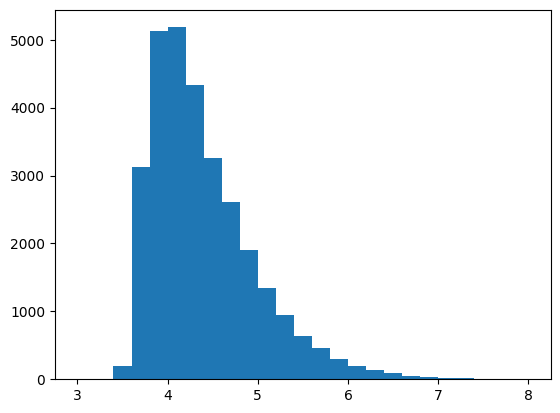

In [ ]:
# fluxes
plt.hist(ds['noiseless'].sum(axis=(1,2,3)).log10(), bins=25, range=(3, 8))

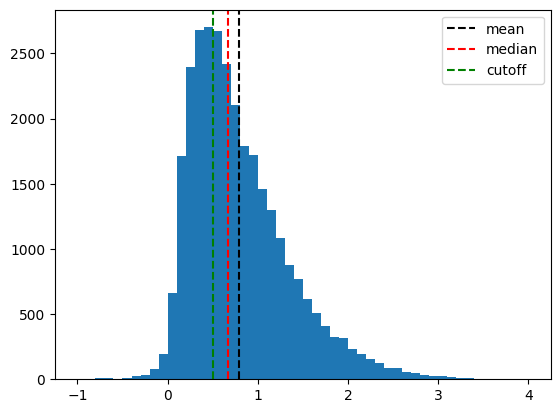

In [ ]:
# consider only using galaxies before histogram starts decreasing on left side (completeness argument)
plt.hist(snr.log10(), bins=50, range=(-1, 4))

plt.axvline(snr.log10().mean(), linestyle='--', color='k', label='mean')
plt.axvline(snr.log10().median(), linestyle='--', color='r', label='median')
plt.axvline(0.5, color='g', linestyle='--', label='cutoff')
plt.legend()



/home/imendoza/bliss/bliss/plotting.py:256: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_bin: np.ndarray = y[keep_x]


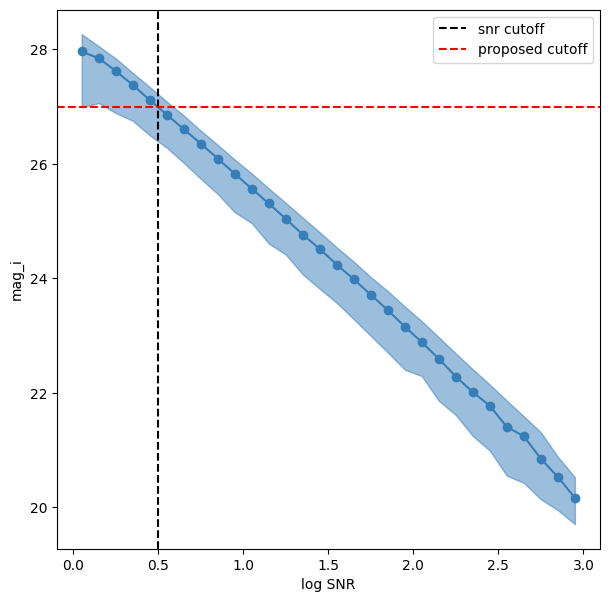

In [ ]:
from bliss.plotting import scatter_shade_plot
fig, ax = plt.subplots(1, 1, figsize=(7,7))
mags = ds['galaxy_params'][:, -2]
scatter_shade_plot(ax, snr.log10(), mags, xlims=(0.0, 3.0), delta=0.1, qs=(0.025, 0.975)) ## 99% CI
plt.ylabel("mag_i")
plt.xlabel("log SNR")
plt.axvline(0.5, color='k', linestyle='--', label='snr cutoff')
plt.axhline(27.0, color='r', linestyle='--', label='proposed cutoff')

plt.legend()

In [ ]:
snr.shape, mags.shape

(torch.Size([30000]), torch.Size([30000]))

In [ ]:
# how many galaxies have snr < 0.5 with this cutoff
mask = mags < 27.0
np.sort(snr[mask].log10())[:20], sum(snr[mask].log10() < 0.5) / len(snr) # ~ 3% of galaxies 

(array([-0.60682485, -0.54168031, -0.34586283, -0.3423257 , -0.21459808,
        -0.20816482, -0.20088308, -0.16504333, -0.15970989, -0.15797424,
        -0.15247095, -0.1265991 , -0.12630639, -0.08311544, -0.06443528,
        -0.05831322, -0.054476  , -0.054476  , -0.04926083, -0.02273583]),
 tensor(0.0371))

In [ ]:
# check ellipticity as last thing
from bliss.reporting import get_single_galaxy_ellipticities

ellips = get_single_galaxy_ellipticities(ds['noiseless'][:, 0, :, :], no_bar=False)

Measuring galaxies: 100%|██████████| 30000/30000 [00:07<00:00, 4089.91it/s]


In [ ]:
ellips.shape

torch.Size([30000, 2])

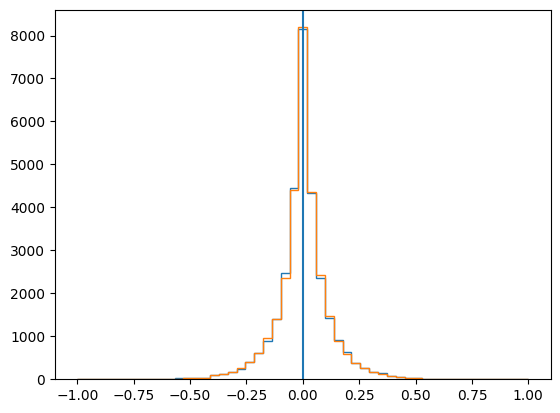

In [ ]:
_, bins, _ = plt.hist(ellips[:, 0], histtype='step', bins=51, range=(-1.0, 1.0))
plt.hist(ellips[:, 1], histtype='step', bins=bins)
plt.axvline(0.0)

In [ ]:
e1 = ellips[:, 0].numpy()
e2 = ellips[:, 1].numpy()
mask = ~np.isnan(e1)
np.mean(e1[mask]), np.mean(e2[mask])

(6.823365e-05, 9.8124554e-05)

In [ ]:
e1 = ellips[:, 0].numpy()
e2 = ellips[:, 1].numpy()
mask = ~np.isnan(e1)
np.std(e1[mask]), np.std(e2[mask])

(0.11717263, 0.1165174)